In [14]:
import torch, gc
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
from numpy import uint8
from src.dataset import ImageDataset
from src.utils import get_indices, plot_result
from src.loss_functions import FFTloss, VGGPerceptualLoss
from src.mwcnn import MWCNN
from src.training import Trainer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()
# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 1
# Dataset folder used
# DATASETS = ['e9_5_GLM87a_cycle1_8_8', 'e12_5_slide7_round1_section1']
DATASETS = ["test_1"]
ROOTDIR = 'data'
# Training Epochs
EPOCHS = 100

## 1 Initiate train and test loader

In [2]:
image_dataset = ImageDataset(ROOTDIR, DATASETS, normalize="percentile", image_size=2048)

train_indices, test_indices = get_indices(len(image_dataset), image_dataset.root_dir, TEST_SPLIT)
train_sampler, test_sampler = SubsetRandomSampler(test_indices[0:2]), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(image_dataset, 1) #, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(image_dataset, 1) #, sampler=test_sampler)

data\mip2edof_2samples/e9_5_GLM87a_cycle1_8_8


FileNotFoundError: [Errno 2] No such file or directory: 'data\\mip2edof_2samples/e9_5_GLM87a_cycle1_8_8'

## 1.1 Show example of images

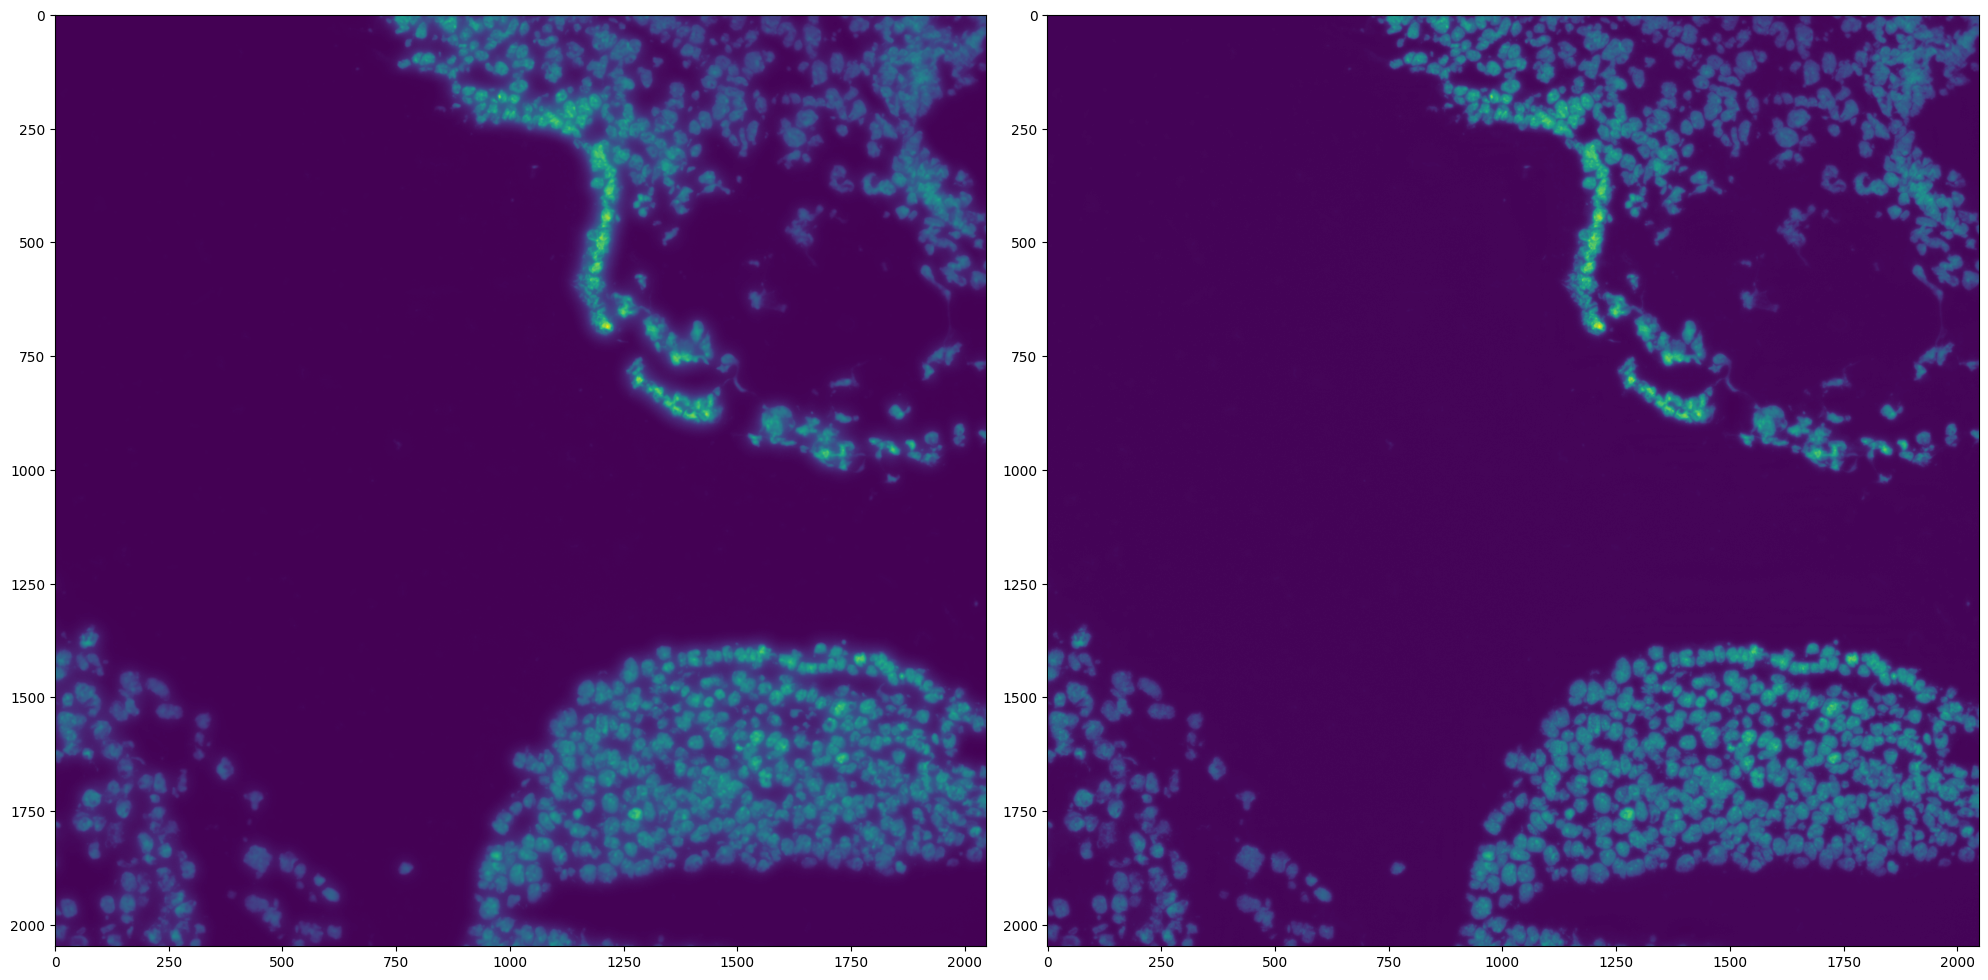

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 60))
image_index = 0
sample = image_dataset[image_index]

ax[0].imshow(sample["input_image"].squeeze(), aspect='equal')
ax[1].imshow(sample["output_image"].squeeze(), aspect='equal')

plt.tight_layout()
plt.show()

## 2 Initiate model

In [15]:
torch.cuda.set_per_process_memory_fraction(0.99, 0)
gc.collect()
torch.cuda.empty_cache()

In [16]:
N_FEATS = 64
criteria = [VGGPerceptualLoss(resize=False), FFTloss(device=device, han_window=True), FFTloss(device=device, han_window=False), torch.nn.L1Loss()]
criteria_names = ["VGGloss", "fftloss_han", "fftloss", "l1loss"]
batch_norms = [True, False]
batch_norm_names = ["true", "false"]
normalization = ["minmax", "percentile", "standard", ""]
for norm_method in normalization:
    for criterion, crit_name in zip(criteria, criteria_names):
        for batchnorm, batch_norm_name in zip(batch_norms, batch_norm_names):
            image_dataset = ImageDataset(ROOTDIR, DATASETS, normalize=norm_method, image_size=1024)
            trainloader = torch.utils.data.DataLoader(image_dataset, 1)

            # Create model
            MWCNN_model = MWCNN(n_feats=N_FEATS, n_colors=1, batch_normalize=batchnorm).to(device)
            
            # Training
            MWCNN_trainer = Trainer(MWCNN_model, criterion, device, clear_cache=True)
            loss_record = MWCNN_trainer.train(EPOCHS,trainloader,mini_batch=1)

            # Test
            sample = image_dataset[0]
            mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
            print(f"Normalization: {norm_method}, Criterion: {crit_name}, Batch normalization: {batch_norm_name}")
            print(f"MIP PSNR score is: {original_score}. The improved PSNR is: {improved_score}")
            torch.save(MWCNN_model, f'models/MWCNN_model_{crit_name}_feats_{N_FEATS}_batchnorm_{batch_norm_name}_norm_{norm_method}.pth')

            # save test result
            im = Image.fromarray(pred.astype(uint8))
            im.save(f"results/MWCNN_model_{crit_name}_feats_{N_FEATS}_batchnorm_{batch_norm_name}_norm_{norm_method}.jpeg")
        

        


/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Starting Training Process
Epoch: 001,  Loss:9.9960842,  
Epoch: 010,  Loss:2.2568505,  
Epoch: 020,  Loss:1.2381177,  
Epoch: 030,  Loss:1.6891736,  
Epoch: 040,  Loss:1.9823731,  
Epoch: 050,  Loss:1.6064955,  
Epoch: 060,  Loss:1.3008614,  
Epoch: 070,  Loss:1.4182817,  
Epoch: 080,  Loss:1.6126264,  
Epoch: 090,  Loss:1.5351136,  
Epoch: 100,  Loss:1.5483735,  
Normalization: minmax, Criterion: VGGloss, Batch normalization: true
MIP PSNR score is: 34.947267432622056. The improved PSNR is: 6.771787794353086
Starting Training Process
Epoch: 001,  Loss:1.6924971,  
Epoch: 010,  Loss:0.3917233,  
Epoch: 020,  Loss:0.2607336,  
Epoch: 030,  Loss:0.2741691,  
Epoch: 040,  Loss:0.3770439,  
Epoch: 050,  Loss:0.2918916,  
Epoch: 060,  Loss:0.3019254,  
Epoch: 070,  Loss:0.1455131,  
Epoch: 080,  Loss:0.2652421,  
Epoch: 090,  Loss:0.5259595,  
Epoch: 100,  Loss:0.3936845,  
Normalization: minmax, Criterion: VGGloss, Batch normalization: false
MIP PSNR score is: 28.979501881379623. The impro

Starting Training Process
Epoch: 010,  Loss:153.1479645,  
Epoch: 020,  Loss:77.1148148,  
Epoch: 030,  Loss:45.2756119,  
Epoch: 040,  Loss:37.5160217,  
Epoch: 050,  Loss:34.6700134,  
Epoch: 060,  Loss:33.2290115,  
Normalization: minmax, Criterion: fftloss, Batch normalization: true
MIP PSNR score is: 33.9366554542716. The improved PSNR is: 9.125550605119392
Starting Training Process
Epoch: 010,  Loss:31.7220516,  
Epoch: 020,  Loss:29.9657135,  
Epoch: 030,  Loss:28.2247639,  
Epoch: 040,  Loss:26.9274158,  
Epoch: 050,  Loss:27.2215919,  
Epoch: 060,  Loss:27.1117420,  
Normalization: minmax, Criterion: fftloss, Batch normalization: false
MIP PSNR score is: 33.936653039375784. The improved PSNR is: 31.723119084798395

C:\Users\jurri\AppData\Local\Temp\ipykernel_14016\3673249755.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


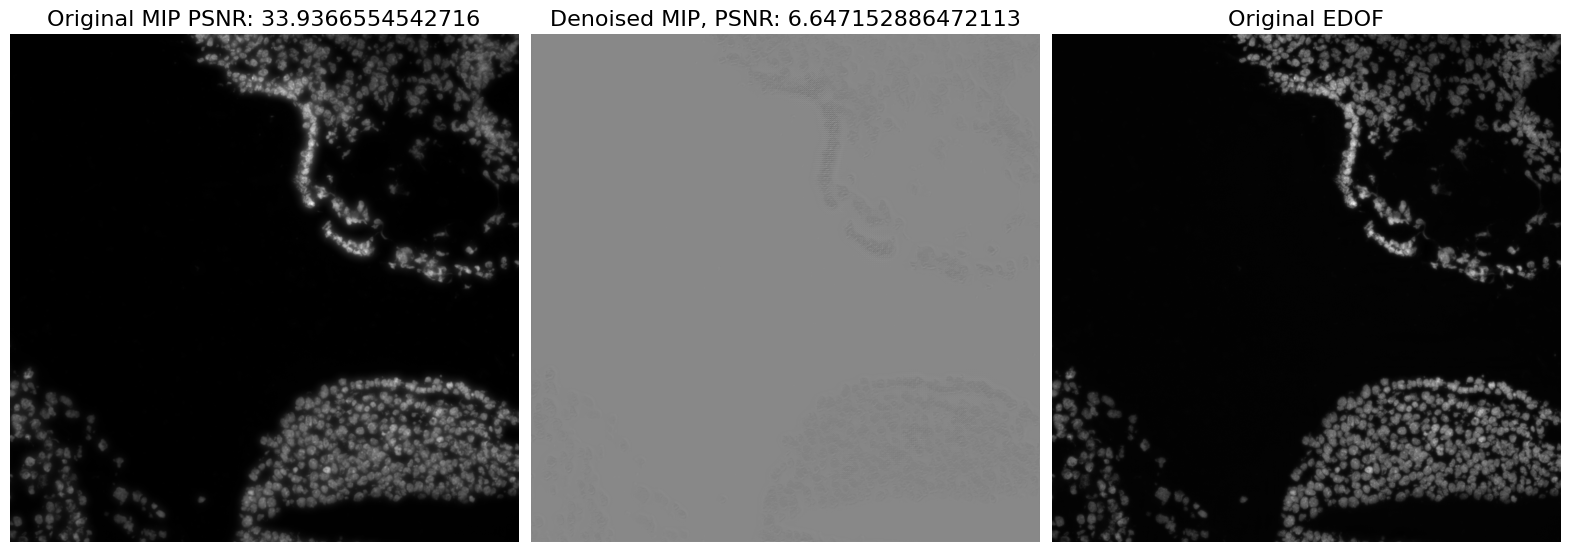

In [4]:
# model = torch.load("models/MWCNN_model_fftloss_feats_16_batchnorm_true_norm_minmax.pth")
model = MWCNN_model
image_dataset = ImageDataset(ROOTDIR, DATASETS, normalize="percentile", image_size=2048)

criterion = FFTloss(device=device)
MWCNN_trainer = Trainer(model, criterion, device)

sample = image_dataset[0]
mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)

results = []
results.append({
    "MIP": mip,
    "pred": pred,
    "EDOF": edof,
    "original_score": original_score,
    "improved_score": improved_score
})

fig, axs = plt.subplots(len(results), 3, sharex=True, sharey=True, figsize=(
    20, 15), 
    gridspec_kw={'wspace': 0.025, 'hspace': 0.10}
)
for i in range(len(results)):
    axs[0].set_title(f"Original MIP PSNR: {results[i]['original_score']}", fontdict={'fontsize': 16})
    axs[0].imshow(results[i]["MIP"], cmap='gray')
    axs[0].set_axis_off()

    axs[1].set_title(f"Denoised MIP, PSNR: {results[i]['improved_score']}", fontdict={'fontsize': 16})
    axs[1].imshow(results[i]["pred"], cmap='gray')
    axs[1].set_axis_off()

    axs[2].set_title("Original EDOF", fontdict={'fontsize': 16})
    axs[2].imshow(results[i]["EDOF"], cmap='gray')
    axs[2].set_axis_off()

plt.tight_layout()
plt.show()

## 3. Model Training and Testing

In [28]:
# Training
criterion = torch.nn.L1Loss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

In [29]:
loss_record = MWCNN_trainer.train(EPOCHS,trainloader,mini_batch=1)

print(f'Training finished!')

Starting Training Process
Batch: 01,	Batch Loss: 129.5687103
Epoch: 001,  Loss:129.5687103,  
Batch: 01,	Batch Loss: 111.7089157
Epoch: 002,  Loss:111.7089157,  
Batch: 01,	Batch Loss: 113.5931625
Epoch: 003,  Loss:113.5931625,  
Batch: 01,	Batch Loss: 116.4254150
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 004,  Loss:116.4254150,  
Batch: 01,	Batch Loss: 113.9763031
Epoch: 005,  Loss:113.9763031,  
Batch: 01,	Batch Loss: 112.6401825
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 006,  Loss:112.6401825,  
Batch: 01,	Batch Loss: 111.4369202
Epoch: 007,  Loss:111.4369202,  
Batch: 01,	Batch Loss: 110.6347733
Epoch: 008,  Loss:110.6347733,  
Batch: 01,	Batch Loss: 109.8984985
Epoch: 009,  Loss:109.8984985,  
Batch: 01,	Batch Loss: 108.8241577
Epoch: 010,  Loss:108.8241577,  
Batch: 01,	Batch Loss: 107.1631012
Epoch: 011,  Loss:107.1631012,  
Batch: 01,	Batch Loss: 104.6798477
Epoch: 012,  Loss:104.6798477,  
Batch: 01,	Batch Loss: 105.2080154

## Test model

In [31]:
# Testing process on test data.
mwcnn_psnr, mwcnn_mse = MWCNN_trainer.test(trainloader)
print(f'PSNR: {mwcnn_psnr}, MSE: {mwcnn_mse}')

AttributeError: 'SequentialSampler' object has no attribute 'indices'

## Save model

In [6]:
# save the model
torch.save(MWCNN_model, 'MWCNN_model_fft_16.pth')

## Show predictions from trained models

In [16]:
# load model
MWCNN_model = torch.load('MWCNN_model_L1loss_16.pth')
# make trainer for testing, predicting and possibly more training
criterion = FFTloss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

Do x predictions

In [36]:
num_pred = 2
results = []
for i in range(num_pred):
    image_index = test_indices[i]
    sample = image_dataset[image_index]
    mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
    results.append({
        "MIP": mip,
        "pred": pred,
        "EDOF": edof,
        "original_score": original_score,
        "improved_score": improved_score
    })

c:\Users\jurri\Documents\University\Life sciences and engineering\Deep learning in biomedicine\project\deep-biomedicine-project\src\utils.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


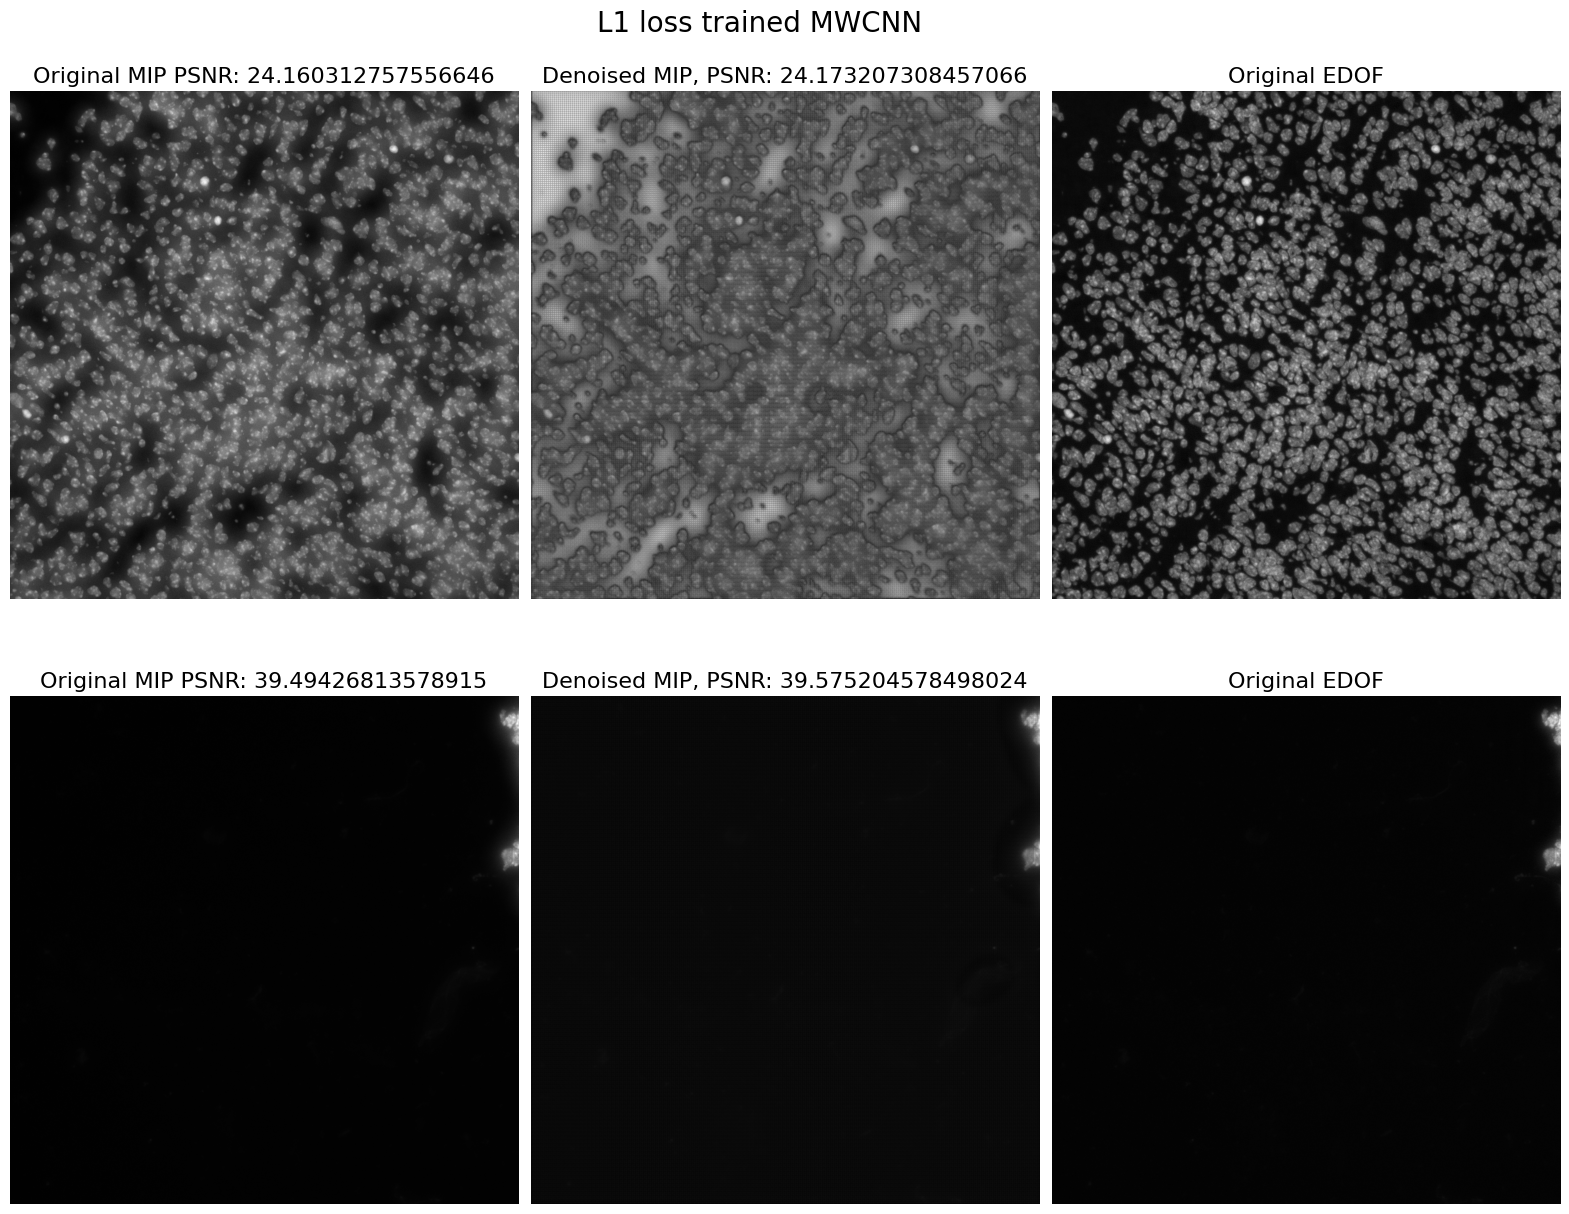

In [37]:
# plot results
plot_result(results, "L1 loss trained MWCNN")

In [6]:
# load model
MWCNN_model = torch.load('MWCNN_model_fft_16.pth')
# make trainer for testing, predicting and possibly more training
criterion = FFTloss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

In [7]:
results = []
for i in range(num_pred):
    image_index = test_indices[i]
    sample = image_dataset[image_index]
    mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
    results.append({
        "MIP": mip,
        "pred": pred,
        "EDOF": edof,
        "original_score": original_score,
        "improved_score": improved_score
    })

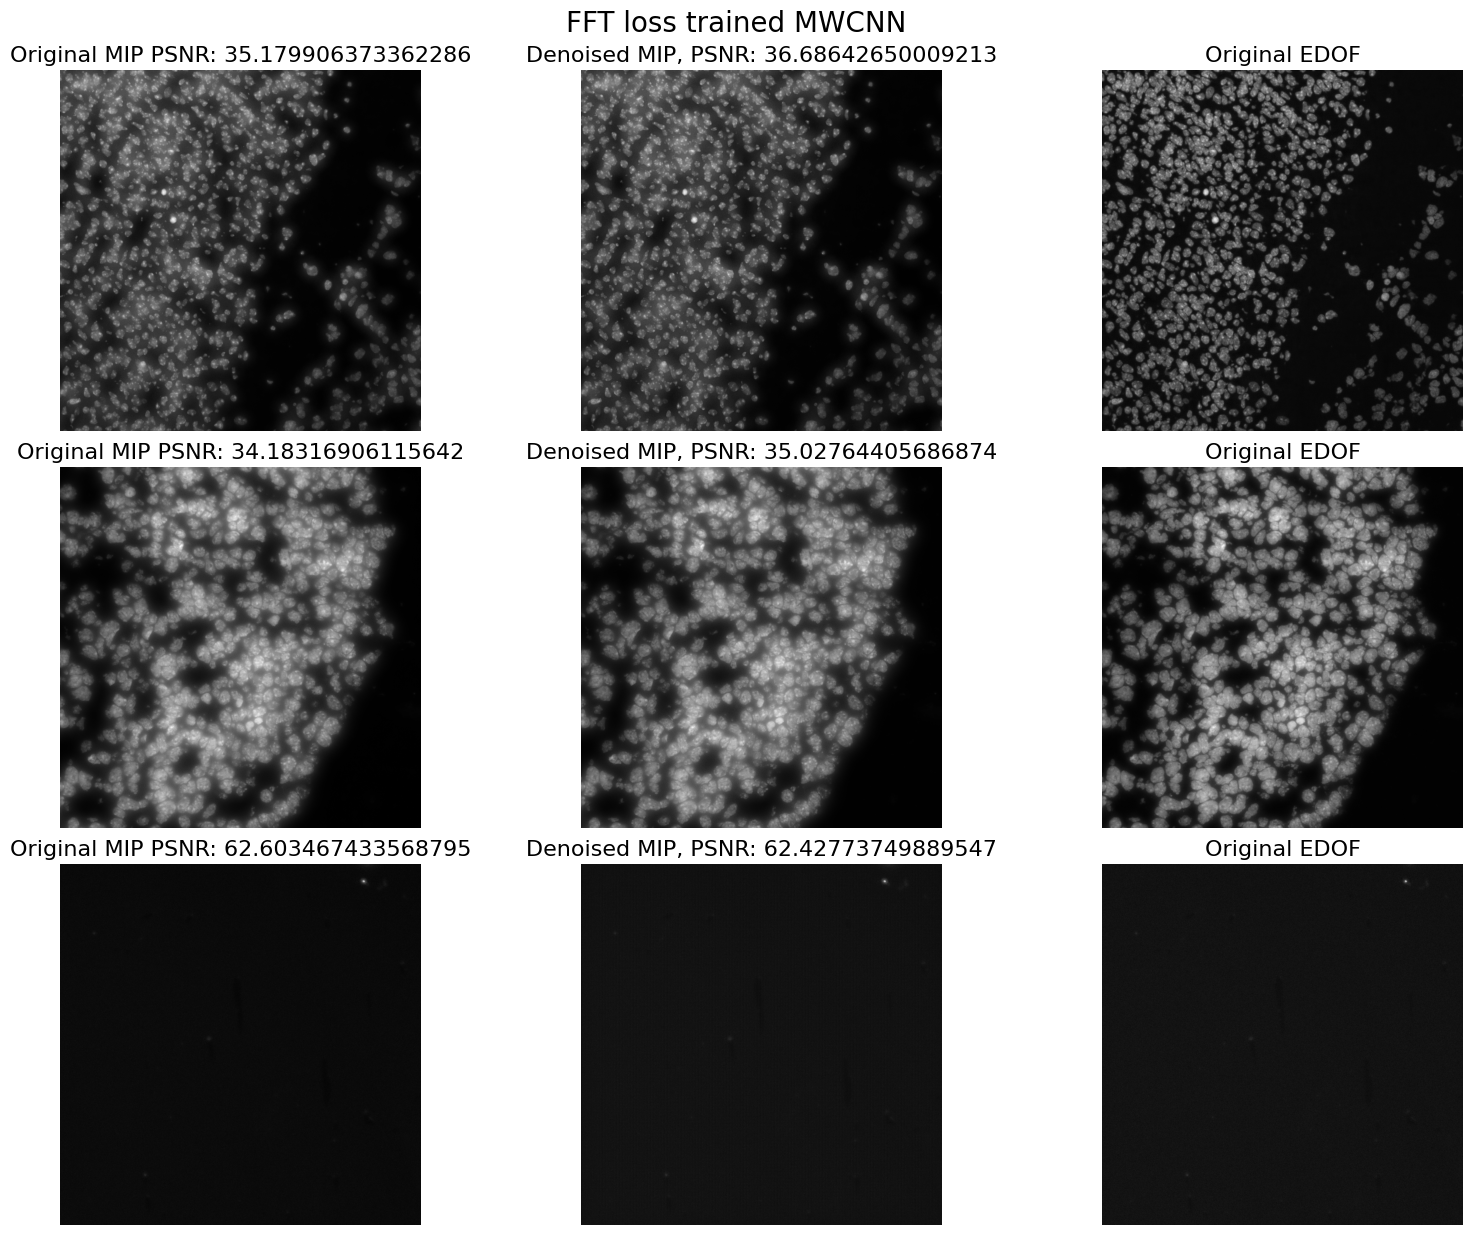

In [8]:
# plot results
plot_result(results, "FFT loss trained MWCNN")